# Predicting house prices

![](https://cdn.pixabay.com/photo/2017/04/14/17/17/houses-2230817_960_720.png)

### About the kernel

>**Note!** *My purpose with this kernel is primarily to try different ML algorithms and to learn about hyperparameter tuning, stacking and ensambling.*
>*I am therefore not including much EDA in this kernel and I am not describing the data cleaning- and feature engineering (FE) in details. I will refer to other kernels instead, as many others have already done an outstanding job doing in these regards!*  


### Contents:    
* **1 Data**
  * 1.1 Importing data
  * 1.2 Exploratory Data Analysis (light)
* **2 Data cleaning**  
  * 2.1 Outliers  
  * 2.2 Handling skew and null   
  * 2.3 Light feature engineering  
* **3 Data preparation: Encode and scale**   
* **4 Model fit**  
  * 4.1 Hyper parameter tuning with GridSearch  
  * 4.2 Stacking  
  * 4.3 Emsambling  
* **5 Predictions**  
  * 5.1 Comparison of models

Credit goes to (they deserve an upvote!):   
https://www.kaggle.com/shaygu/house-prices-begginer-top-7  
https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb   
https://www.kaggle.com/iamprateek/my-submission-to-predict-sale-price/data   
https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1#Blending-Models

# 1 Data

In [1]:
#Importing the libraries used for the first couple of steps
import pandas as pd
import numpy as np

#AND suppressing warning; they tend to ruin an easy overview
import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

## 1.1 Importing data

In [2]:
def import_data(data):
    df = pd.read_csv('../input/house-prices-advanced-regression-techniques/{}.csv'
                     .format(data))
    return df

train = import_data('train')
train = train.set_index('Id')
test = import_data('test')
ID = test[['Id']]
test = test.set_index('Id')

## 1.2 EDA (light)

*Getting to know the dataset!!!*  

We want to get an overview of the dataset, so we know which measures to take in order to get a nice and clean dataset to feed our machine learning models with.  

I am starting with answering questions such as the shape (rows, columns) of both the training and the testing dataset, how many null values are in each row etc. The purpose of this dataset is not EDA, so if you are looking for a comprehensive overview, I will recommend moving on to another kernel :-)

How many rows and columns are we dealing with?

In [3]:
print(
    'Train dataset has {} rows and {} columns\nTest dataset has {} rows and {} columns'
      .format(train.shape[0],
              train.shape[1],
              test.shape[0],
              test.shape[1]
             )
    )

Train dataset has 1460 rows and 80 columns
Test dataset has 1459 rows and 79 columns


The train dataset has one more columns than the test dataset - this is the target value, SalePrice!  

The next step is to combine the two datasets for consistency, when I handle nulls and skew values and when encoding and scaling.  

Let's also have a look at the data; which columns do we have, split into qualitative and quantitative columns.

In [4]:
#defining qualitative and quantitative columns
qual_cols = [col for col in train.columns if train[col].dtype in ['object', 'str']]
quan_cols = [col for col in train.columns if train[col].dtype not in ['object', 'str']]

print('Qualitative columns ({} columns):\n{}\n'.format(len(qual_cols), train[qual_cols].columns))
print('Quanitative columns ({} columns):\n{}'.format(len(quan_cols), train[quan_cols].columns))

Qualitative columns (43 columns):
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Quanitative columns (37 columns):
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 

**Let's get an overview of the first 5 rows of the dataset:**

In [5]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2 Data cleaning

## 2.1 Outliers

**Identifying outliers**  

Identifying most correlated features and using z-score to remove outliers.  
One solution is to remove outliers with a z-score > 3.  
This does not improve score, so it is not integrated, but the code is still found below.

Instead I use data vizualization, a pairplot, to identify outliers and then filter them out.


Z-scores:

In [6]:
from scipy import stats

# defining top correlated features

corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.6]

for kol in top_corr_features:
    z = np.abs(stats.zscore(train[kol]))
    train['z'] = z
    #train = train[train.z < 3.5]
    train = train.drop('z', axis = 1)

Top correlated features:

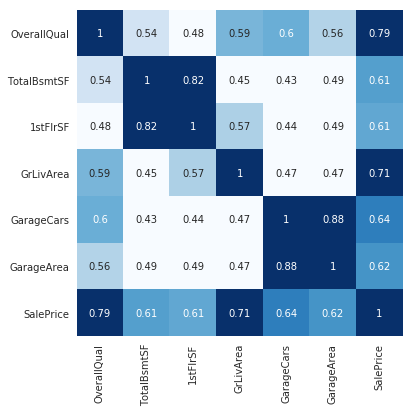

In [7]:
#Importing libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Setting style to 'darkgrid'
sns.set_style('darkgrid')

plt.figure(figsize=(6,6))
g = sns.heatmap(
    train[top_corr_features].corr(), 
    annot = True, cmap = "Blues", 
    cbar = False, vmin = .5, 
    vmax = .7, square=True
    )

Using a pairplot to check that all obvious outliers are in fact removed

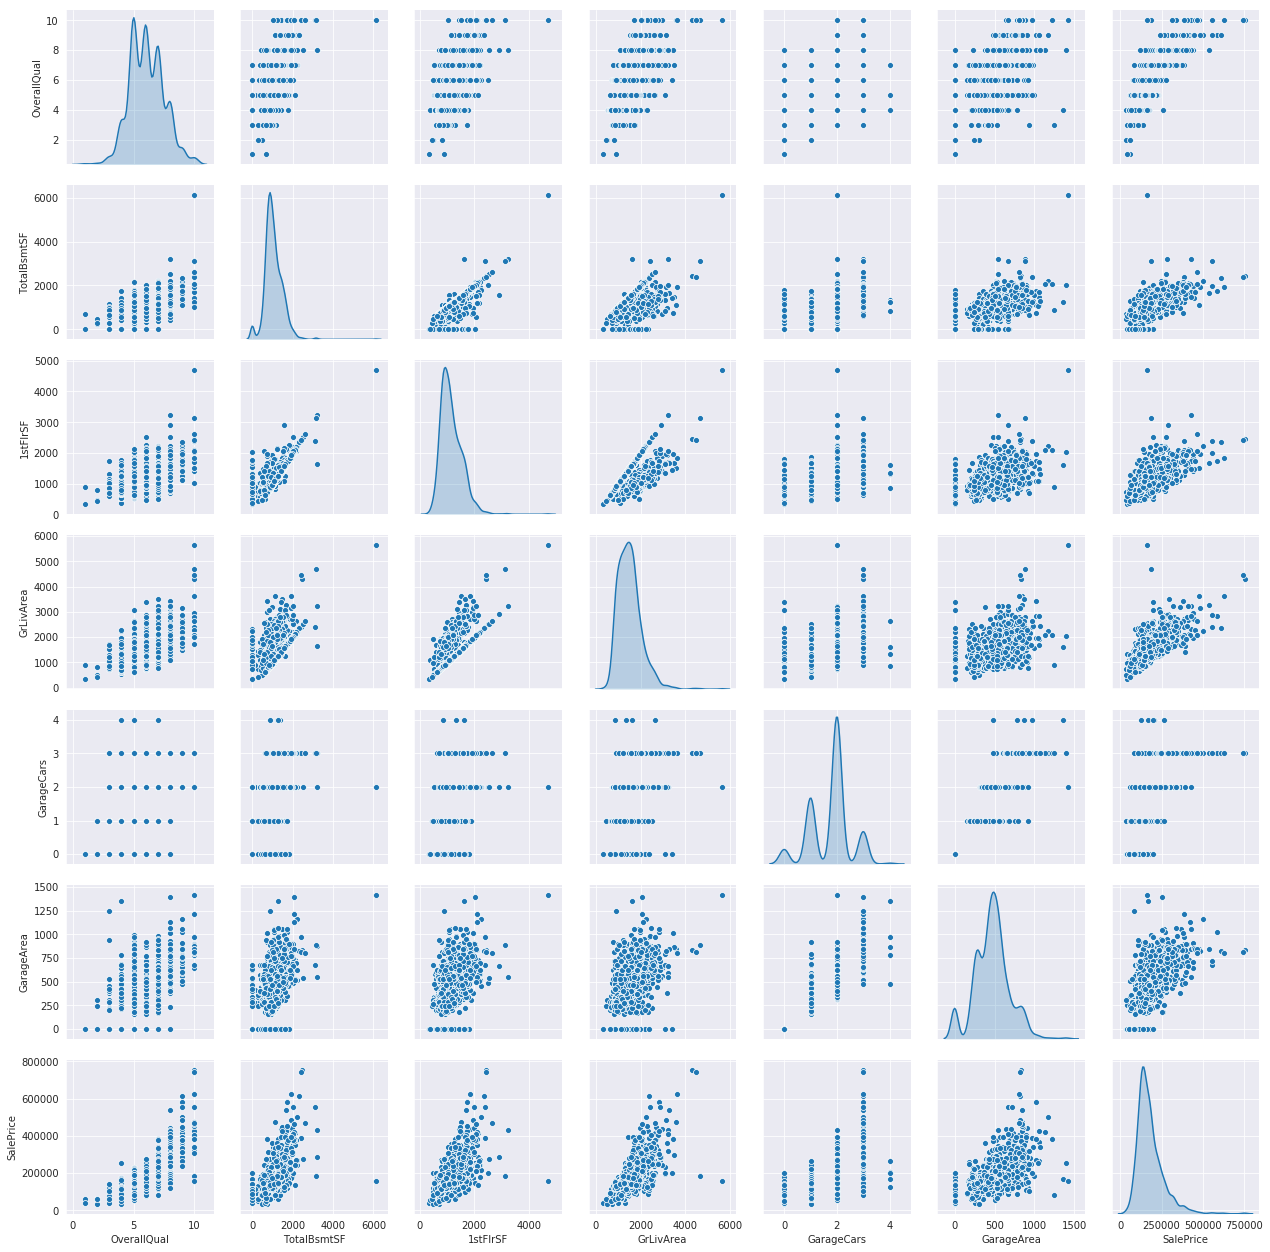

In [8]:
sns.pairplot(train[top_corr_features], diag_kind='kde')

We set a couple of filters based on the above (see also other kernels for in depth review)

In [9]:
#train = train[(train['SalePrice']<450000) & (train['GrLivArea']<4000) & (train.TotalBsmtSF<3000)]
train = train[(train['GrLivArea']<4500)]

## 2.2 Handling skew for target

Let's first look into our target variable: SalePrice.  

When skewed, we apply np.log1p to: *"Return the natural logarithm of one plus the input array, element-wise."*

The sales prices are skewed quite a bit


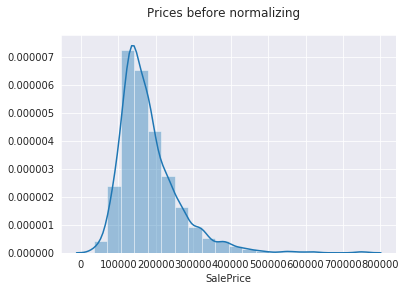

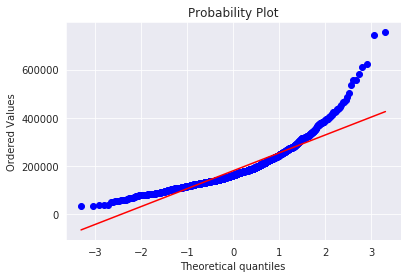

We therefore apply log1p to normalize the sales prices for prediction


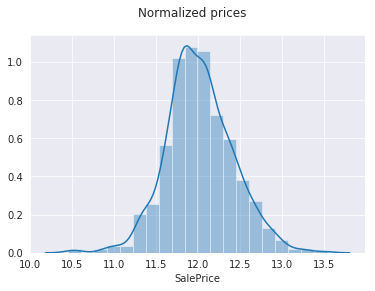

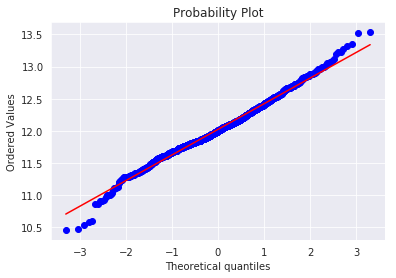

In [10]:
from scipy.stats import probplot

print('The sales prices are skewed quite a bit')
sns.distplot(train.SalePrice, bins=20)
plt.suptitle('Prices before normalizing')
plt.show()

probplot(train.SalePrice, plot=plt)
plt.show()

print('We therefore apply log1p to normalize the sales prices for prediction')
#Normalizing sales price
train["SalePrice"] = np.log1p(train["SalePrice"])

#let's also just defined our target as y:
y = train['SalePrice'].values

sns.distplot(train.SalePrice, bins=20)
plt.suptitle('Normalized prices')
plt.show()

probplot(train.SalePrice, plot=plt)
plt.show()

I am combining the datasets for consistency in the cleaning process.  
SalePrice is dropped from the combined dataset.

In [11]:
df = pd.concat([train.drop(['SalePrice'], axis=1), test], axis=0)

## 2.3 Null values

**Overview of null values in both test and train; top 10 for each**

In [12]:
def null_view(df):
    null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = False)
    null_view = pd.DataFrame(null_view, columns=['n_nulls'])
    null_view['pct_null'] = null_view.n_nulls.apply(lambda x: str(round((x/len(df))*100, 1)) +'%')
    print(null_view.head(10))
null_view(test)
print('')
null_view(train)

              n_nulls pct_null
PoolQC           1456    99.8%
MiscFeature      1408    96.5%
Alley            1352    92.7%
Fence            1169    80.1%
FireplaceQu       730    50.0%
LotFrontage       227    15.6%
GarageYrBlt        78     5.3%
GarageCond         78     5.3%
GarageQual         78     5.3%
GarageFinish       78     5.3%

              n_nulls pct_null
PoolQC           1452    99.6%
MiscFeature      1404    96.3%
Alley            1367    93.8%
Fence            1177    80.7%
FireplaceQu       690    47.3%
LotFrontage       259    17.8%
GarageYrBlt        81     5.6%
GarageType         81     5.6%
GarageFinish       81     5.6%
GarageQual         81     5.6%


In [13]:
#Interpretations of null values
#Credit: see link in the beginning of the kernel

df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

#Fill out values with most common value
commonNa = [
    'MSZoning', 'Electrical',
    'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType',
    'LotFrontage', 'Functional'
    ]

#Fill with zero value
toZero = [
    'MasVnrArea', 'GarageYrBlt',
    'BsmtHalfBath', 'BsmtFullBath',
    'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF'
    ]

#Fill with No data
toNoData = [
    'PoolQC', 'MiscFeature', 
    'Fence','MasVnrType',
    'FireplaceQu', 'GarageType', 
    'GarageFinish', 'GarageQual', 
    'GarageCond', 'BsmtQual', 
    'BsmtCond', 'BsmtExposure', 
    'BsmtFinType1', 'BsmtFinType2',
    'Alley'
    ]

#Function fill missing values
def fillNa_fe(df):
    df['Functional'] = df['Functional'].fillna('Typ')
    for i in commonNa:
        df[i] = df[i].fillna(df[i].mode()[0])
    for i in toNoData:
        df[i] = df[i].fillna('None')
    for i in toZero:
        df[i] = df[i].fillna(0)
    
    df.drop(['Utilities', 'PoolQC', 'MiscFeature'], axis=1, inplace=True)
    
    return df


df = fillNa_fe(df)

### Skew for rest of dataset
Following SalePrice, I will "fix" skew for all other quantitative columns with skre > 0.7.

In [14]:
#Skew is normally >.5, but I have chosen 0.7 in this case
def skew_(df):
    #columns which are skew-candidates
    colls = [col for col in df.columns if df[col].dtype in ['int64','float']]
    skews_df = [col for col in df[colls].columns if abs(df[col].skew()) > .7]

    #function to correct skew
    def skewfix(data, data2):
        for i in data2:
            data[i] = np.log1p(data[i])
            return data
    return skewfix(df, skews_df)

df = skew_(df)

## 2.4 Feature engineering, light  
Inspired by other kernels, I am creating several new variables by combining/altering elements of existing variables.

In [15]:
def feat_eng(df):
    #A little bit of festure engineering
    df['totalSF'] = df['TotalBsmtSF'] \
                   + df['1stFlrSF'] \
                   + df['2ndFlrSF'] \
                   + df['GrLivArea']
    
    df['YrBltAndRemod']= df['YearBuilt'] + df['YearRemodAdd']
    
    df['Porch_SF'] = (df['OpenPorchSF'] \
                      + df['3SsnPorch'] \
                      + df['EnclosedPorch'] \
                      + df['ScreenPorch'] \
                      + df['WoodDeckSF'])
    
    df['Total_Bathrooms'] = (df['FullBath'] \
                             + (0.5 * df['HalfBath']) \
                             + df['BsmtFullBath'] \
                             + (0.5 * df['BsmtHalfBath']))   
    
    df['hpool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['h2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

df = feat_eng(df)

# 3 Data preparation

In order to use qualitative variables I am encoding and scaling the variables.

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

#We need to encode variables with categorical data:
encoder = LabelEncoder()
sc = StandardScaler()

def encode(df):
    cat_df = [col for col in df.columns if df[col].dtype not in ['int','float']]
    for col in cat_df:
        df[col] = encoder.fit_transform(df[col])
    df_ = sc.fit_transform(df)
    df = pd.DataFrame(data=df_, columns = df.columns)
    return df


'''
Testing dummies in this commit; scores better than encoding!

'''

df = pd.get_dummies(df)

#df = encode(df)

# 4 Model fit

In [17]:
train = df.iloc[:train.shape[0],:]
test  = df.iloc[train.shape[0]:,:]

In [18]:
#Splitting dataset into test and train
from sklearn.model_selection import train_test_split

X = train.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 4.1 Hyper parameter tuning with GridSearch



**Five models with gradient boost first defined:**  
>Gradient Boost  
>Light GBM  
>XGBoost  
>K-nearest neighbors  
>Random forest

**I have been going through several possibilities in gridsearch, below is only the latest "best parameters"**

In [19]:
import datetime

#Import library for Gridsearch
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [20]:
#Importing regressor for each model, as below
from lightgbm import LGBMRegressor

print('####################################################\n{}\tLightBGM'
      .format(datetime.datetime.now().strftime('%H:%M')))

parameters = {
    'objective':['regression'],
    'num_leaves':[5],
    'learning_rate':[0.05], #0.005, 
    'n_estimators':[720], #, 4000, 5000 
    'max_bin':[55], #, 300, 500
    'max_depth':[2, 3],
    'bagging_fraction':[.5, .8],
    'bagging_freq':[5],
    'bagging_seed':[9], #7
    'feature_fraction':[0.2319],#0.2, 
    'feature_fraction_seed':[9] #5
    }

light = LGBMRegressor()
clf = GridSearchCV(light, parameters, verbose=0, iid=False)
clf.fit(X_train, y_train)
lightgbm = LGBMRegressor(**clf.best_params_)

print('\nRegressor: \n', lightgbm, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
08:24	LightBGM

Regressor: 
 LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=2, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=720, n_jobs=-1, num_leaves=5,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0) 

08:24	Done!
####################################################


In [21]:
from xgboost import XGBRegressor
print('####################################################\n{}\tXGBoost'
      .format(datetime.datetime.now().strftime('%H:%M')))

params = {
    'colsample_bytree': [0.4],
    'gamma': [0.0],
    'learning_rate': [0.01], 
    'max_depth': [3],
    'min_child_weight': [2],
    'n_estimators': [3460],
    'seed': [36],
    'subsample': [0.2],
    'objective':['reg:squarederror'],
    'reg_alpha':[0.00006],
    'cale_pos_weight':[1],
    'verbosity':[0]
    }

gbm = XGBRegressor()
clf = GridSearchCV(gbm, params, verbose=0, iid=False)
clf.fit(X_train,y_train)
XGBoost = XGBRegressor(**clf.best_params_)

print('\nRegressor: \n', XGBoost, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
08:24	XGBoost

Regressor: 
 XGBRegressor(base_score=0.5, booster='gbtree', cale_pos_weight=1,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
             gamma=0.0, importance_type='gain', learning_rate=0.01,
             max_delta_step=0, max_depth=3, min_child_weight=2, missing=None,
             n_estimators=3460, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=36, silent=None,
             subsample=0.2, verbosity=0) 

08:25	Done!
####################################################


In [22]:
from sklearn.ensemble import GradientBoostingRegressor
print('####################################################\n{}\tGradient Boost'
      .format(datetime.datetime.now().strftime('%H:%M')))

parameters = {
    'n_estimators':[8000,],
    'learning_rate':[0.01], 
    'max_depth':[2], 
    'max_features':['sqrt'], 
    'min_samples_leaf':[10], 
    'min_samples_split':[5], 
    'loss':['huber'], 
    'random_state' :[42],
    }

gbr = GradientBoostingRegressor()
clf = GridSearchCV(gbr, parameters, verbose=0, iid=False)
clf.fit(X_train, y_train)
gbr = GradientBoostingRegressor(**clf.best_params_)

print('\nRegressor: \n', gbr, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
08:25	Gradient Boost

Regressor: 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=8000,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 

08:26	Done!
####################################################


In [23]:
from sklearn.neighbors import KNeighborsRegressor
print('####################################################\n{}\tK-nearest neighbor'
      .format(datetime.datetime.now().strftime('%H:%M')))

parameters = {
    'algorithm':['auto'],
    'leaf_size':[2],
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan'],
    'n_neighbors':[10],
    }

knn = KNeighborsRegressor()
clf = GridSearchCV(knn, parameters, verbose=0, iid=False)
clf.fit(X_train, y_train)
knn = KNeighborsRegressor(**clf.best_params_)

print('\nRegressor: \n', knn, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
08:26	K-nearest neighbor

Regressor: 
 KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance') 

08:26	Done!
####################################################


In [24]:
from sklearn.ensemble import RandomForestRegressor
print('####################################################\n{}\tRandom forest'
      .format(datetime.datetime.now().strftime('%H:%M')))

parameters = {
    'bootstrap': [True],
    #'max_depth': [15],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [4],
    'n_estimators': [1500],
    'n_jobs':[-1],
    'oob_score':[True]
    }

r_forest = RandomForestRegressor()
clf = GridSearchCV(r_forest, parameters, verbose=0, iid=False)
clf.fit(X_train, y_train)
knn = RandomForestRegressor(**clf.best_params_)

print('\nRegressor: \n', knn, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
08:26	Random forest

Regressor: 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                      warm_start=False) 

08:26	Done!
####################################################


**Pipelines for following models defined:**  
>Ridge  
>Lasso  
>Elasticnet  
>SVR

In [25]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

#Imporing library for makign pipeline
from sklearn.pipeline import make_pipeline

In [26]:
from sklearn.linear_model import RidgeCV

alphas_ridge = [
    14.5, 14.6, 14.7, 14.8, 14.9, 15, 
    15.1, 15.2, 15.3, 15.4, 15.5, 15.6
    ]

ridge = make_pipeline(
    RobustScaler(), 
    RidgeCV(
        alphas=alphas_ridge, 
        cv=kfolds
        )
    )

print('############################################################\nRidge: \n', 
      ridge, 
      '\n############################################################\n')

############################################################
Ridge: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5,
       15.6]),
                         cv=KFold(n_splits=10, random_state=42, shuffle=True),
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False) 
############################################################



In [27]:
from sklearn.linear_model import LassoCV

alphas_lasso = [
    5e-05, 0.0001, 0.0002, 0.0003, 
    0.0004, 0.0005, 0.0006, 0.0007
    ]

lasso = make_pipeline(
    RobustScaler(), 
    LassoCV(
        alphas=alphas_lasso, 
        max_iter=1e7, 
        random_state=42, 
        cv=kfolds
        )
    )

print('############################################################\nLasso: \n', 
      lasso,
      '\n############################################################\n')

############################################################
Lasso: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lassocv',
                 LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                 0.0006, 0.0007],
                         copy_X=True,
                         cv=KFold(n_splits=10, random_state=42, shuffle=True),
                         eps=0.001, fit_intercept=True, max_iter=10000000.0,
                         n_alphas=100, n_jobs=None, normalize=False,
                         positive=False, precompute='auto', random_state=42,
                         selection='cyclic', tol=0.0001, verbose=False))],
         verbose=False) 
############################################################



In [28]:
from sklearn.linear_model import ElasticNetCV

alphas_ela = [
    0.0001, 0.0002, 0.0003, 
    0.0004, 0.0005, 0.0006, 0.0007
    ]

e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elasticnet = make_pipeline(
    RobustScaler(), 
    ElasticNetCV(
        max_iter=1e7, 
        alphas=alphas_ela, 
        cv=kfolds, 
        l1_ratio=e_l1ratio
        )
    ) 

print('############################################################\nElastic: \n',
      elasticnet, 
      '\n############################################################\n')

############################################################
Elastic: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnetcv',
                 ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                      0.0006, 0.0007],
                              copy_X=True,
                              cv=KFold(n_splits=10, random_state=42, shuffle=True),
                              eps=0.001, fit_intercept=True,
                              l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1],
                              max_iter=10000000.0, n_alphas=100, n_jobs=None,
                              normalize=False, positive=False,
                              precompute='auto', random_state=None,
                              selection='cyclic', tol=0.0001, verbose=0))],
         verbose=Fal

In [29]:
%%time
from sklearn.svm import SVR

parameters = {
   # 'kernel': ['sigmoid'],
    'C':     [120],
    'gamma': [0.0003]
    }

svr_ = SVR()
clf = GridSearchCV(svr_, parameters, verbose=0, iid=False)
clf.fit(X_train, y_train)

svr = make_pipeline(
    RobustScaler(), 
    SVR(**clf.best_params_)
    )

print('############################################################\nSVR: \n', 
      svr, 
      '\n############################################################\n')

############################################################
SVR: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=120, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma=0.0003, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False) 
############################################################

CPU times: user 1.19 s, sys: 4 ms, total: 1.19 s
Wall time: 1.19 s


**Stacking the models:**  

In [30]:
#Importing library for stacking
from mlxtend.regressor import StackingCVRegressor

#SVR, KNN and Random Forest removed!

print('Stacking: \t stack_gen')
stack_gen = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, lightgbm, XGBoost, gbr),
    meta_regressor=XGBoost, 
    use_features_in_secondary=True
    )
print('Done!\n')

print('Stacking: \t stack_gen2')
stack_gen2 = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, lightgbm, XGBoost, gbr),
    meta_regressor=lightgbm, 
    use_features_in_secondary=True
    )
print('Done!\n')

print('Stacking: \t stack_gen3')
stack_gen3 = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, lightgbm, XGBoost, gbr),
    meta_regressor=ridge, 
    use_features_in_secondary=True
    )
print('Done!')

Stacking: 	 stack_gen
Done!

Stacking: 	 stack_gen2
Done!

Stacking: 	 stack_gen3
Done!


**Fitting the models**

In [31]:
models = {
    'svr':svr,
    'Ridge':ridge,
    'Lightgbm':lightgbm,
    'XGBoost':XGBoost,
    'GradientBoost':gbr,
    'Lasso':lasso,
    'Elasticnet':elasticnet,
    'Random forest':r_forest,
    'KNN':knn
    }

#Importing metrics for calculation of error
from sklearn import metrics

def calc(model): 
    return int(np.sqrt(metrics.mean_squared_error(
        np.expm1(y_test), np.expm1(model.predict(X_test)))))

liste = []
for one, two in models.items():
    print('Fitting:\t{}'.format(one))
    two.fit(X_train, y_train)
    print('Done! Error:\t{}\n'.format(calc(two)))
    df = pd.DataFrame(
        data=[calc(two)], 
        index=[one], 
        columns=['error']
        )
    liste.append(df)

Fitting:	svr
Done! Error:	42491

Fitting:	Ridge
Done! Error:	19690

Fitting:	Lightgbm
Done! Error:	23757

Fitting:	XGBoost
Done! Error:	21317

Fitting:	GradientBoost
Done! Error:	20318

Fitting:	Lasso
Done! Error:	19161

Fitting:	Elasticnet
Done! Error:	19154

Fitting:	Random forest
Done! Error:	25449

Fitting:	KNN
Done! Error:	24004



In [32]:
resList = pd.concat(liste, axis=0)

## 4.2 Stacking

In [33]:
print('stack_gen: \t fitting...')
stack_gen_model = stack_gen.fit(np.array(X_test), np.array(y_test))
sg_error = int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(stack_gen_model.predict(np.array(X_test))))))
print('stack_gen: \t done!')
print('error:\t\t', sg_error, '\n')

print('stack_gen2: \t fitting...')
stack_gen_model2 = stack_gen2.fit(np.array(X_test), np.array(y_test))
sg_error2 = int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(stack_gen_model2.predict(np.array(X_test))))))
print('stack_gen2: \t done!')
print('error:\t\t', sg_error2, '\n')

print('stack_gen3: \t fitting...')
stack_gen_model3 = stack_gen3.fit(np.array(X_test), np.array(y_test))
sg_error3 = int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(stack_gen_model3.predict(np.array(X_test))))))
print('stack_gen3: \t done!')
print('error:\t\t', sg_error3)

sg = pd.DataFrame(index=['stack_gen'], data=sg_error, columns=['error'])
sg2 = pd.DataFrame(index=['stack_gen2'], data=sg_error2, columns=['error'])
sg3 = pd.DataFrame(index=['stack_gen3'], data=sg_error3, columns=['error'])

stack_gen: 	 fitting...


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


stack_gen: 	 done!
error:		 6949 

stack_gen2: 	 fitting...


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


stack_gen2: 	 done!
error:		 17219 

stack_gen3: 	 fitting...


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

stack_gen3: 	 done!
error:		 11674


In [34]:
resList = resList.append(sg)
resList = resList.append(sg2)
resList = resList.append(sg3)

## 4.3 Ensambling  
**Ensambling for a bleded prediction model**

In [35]:
def blend(data):
    return (
        #(0.01 * svr.predict(data)) +
        (0.08 * ridge.predict(data)) +
        (0.11 * lightgbm.predict(data)) +
        (0.13 * XGBoost.predict(data)) +
        (0.10 * gbr.predict(data)) +
        (0.15 * stack_gen_model.predict(np.array(data))) +
        (0.16 * stack_gen_model2.predict(np.array(data))) +
        (0.16 * stack_gen_model3.predict(np.array(data))) +
        (0.06 * lasso.predict(data)) +
        #(0.03 * knn.predict(data)) + 
        #(0.02 * r_forest.predict(data)) +
        (0.05 * elasticnet.predict(data)) 
        )

blended_predictions = blend(test)

# 5 Predictions  
## 5.1 Comparing models  
**Comparing the first 20 results for each model**

In [36]:
def createFrame(data):
    '''
    Compare results
    '''
    index = index=import_data('test').reset_index()['Id']
    df_ = {
        'lightgbm':lightgbm.predict(data),
        'XGBoost':XGBoost.predict(data),
        'GBR':gbr.predict(data),
        'svr':svr.predict(data),
        'ridge':ridge.predict(data),
        'elastic':elasticnet.predict(data),
        'lasso':lasso.predict(data),
        'KNN':knn.predict(data),
        'Random forest':r_forest.predict(data),
        'stack_gen':stack_gen_model.predict(np.array(data)),
        'stack_gen2':stack_gen_model2.predict(np.array(data)),
        'stack_gen3':stack_gen_model3.predict(np.array(data)),
        'blended':blend(data)
        }
    df = pd.DataFrame(df_, index=index)
    df = df.applymap(lambda x: np.expm1(x))
    return df

preds = createFrame(test)

for model in preds.columns:
    df = preds[[model]]
    df.rename(columns={model:'SalePrice'}, inplace=True)
    df.to_csv('{}.csv'.format(model))

preds.round(1).head(10)

,lightgbm,XGBoost,GBR,svr,ridge,elastic,lasso,KNN,Random forest,stack_gen,stack_gen2,stack_gen3,blended
Id,,,,,,,,,,,,,
1461,123082.9,127131.0,121895.5,147250.6,116374.6,117668.7,117790.1,122037.0,120510.2,125464.4,124266.1,127951.3,123635.5
1462,162274.9,164850.6,154547.5,162449.5,120180.6,119109.0,119081.4,156383.0,153297.2,166635.7,172021.6,181471.9,157528.2
1463,180050.9,184390.6,192124.0,188276.9,183189.4,181699.1,181739.2,178013.0,181711.2,185558.7,185722.0,184344.8,184652.6
1464,193656.9,198321.9,197633.4,193634.1,201420.8,200762.8,200743.3,183161.9,178101.2,207398.5,215990.0,209319.2,204079.1
1465,195475.1,191557.0,189116.9,192284.3,189383.2,192480.4,192607.2,194100.1,201011.5,181343.2,182061.7,187084.9,187851.7
1466,177023.7,176499.1,182116.8,173850.7,173492.1,175295.5,175298.9,182085.3,187691.5,171106.4,169985.5,166011.7,173153.3
1467,172290.6,173695.6,173729.0,156904.4,180630.3,184531.8,184383.7,169202.6,171921.6,172899.8,171671.5,180802.5,175918.8
1468,163366.9,166426.8,164545.5,162760.6,165224.8,165730.6,165695.7,174022.1,174473.0,169553.2,175984.8,166042.6,167616.8
1469,187271.8,184585.0,185329.7,191992.1,191119.7,195499.4,195466.2,186714.9,183895.2,189275.1,181985.0,188064.6,187480.8


In [37]:
x = blend(X_test)

bl = pd.DataFrame(
    index=['blend'], 
    data=int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(x)))),
    columns=['error']
    )
resList = resList.append(bl)

All models with error

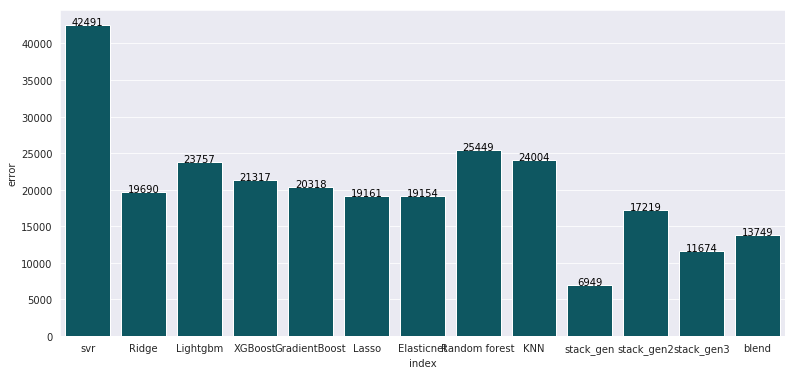

In [38]:
resList2 = resList.reset_index()
#resList2.sort_values('error', inplace=True)
plt.figure(figsize=(13,6))
ax1 = sns.barplot(
    x=resList2['index'], 
    y=resList2.error, 
    color='#00616f'
    )

for i, rows in resList2.iterrows():
    ax1.annotate(
        round(rows['error'],1), 
        xy=(i, rows['error']), 
        xycoords='data', 
        ha='center', 
        color='black'
        )

In [39]:
res = pd.DataFrame(data=np.expm1(blend(test)), index=ID.Id, columns=['SalePrice'])

q1 = res['SalePrice'].quantile(0.005)
q2 = res['SalePrice'].quantile(0.995)

res['SalePrice'] = res['SalePrice'].apply(lambda x: x if x > q1 else x*0.78)
res['SalePrice'] = res['SalePrice'].apply(lambda x: x if x < q2 else x*1.10)

res.to_csv('1_submission.csv')

In [40]:
res.reset_index().head(10)

,Id,SalePrice
0,1461,123635.470295
1,1462,157528.164668
2,1463,184652.644275
3,1464,204079.073939
4,1465,187851.715857
5,1466,173153.277033
6,1467,175918.820149
7,1468,167616.787263
8,1469,187480.834700
9,1470,121627.327521


How are the predictions correlated?

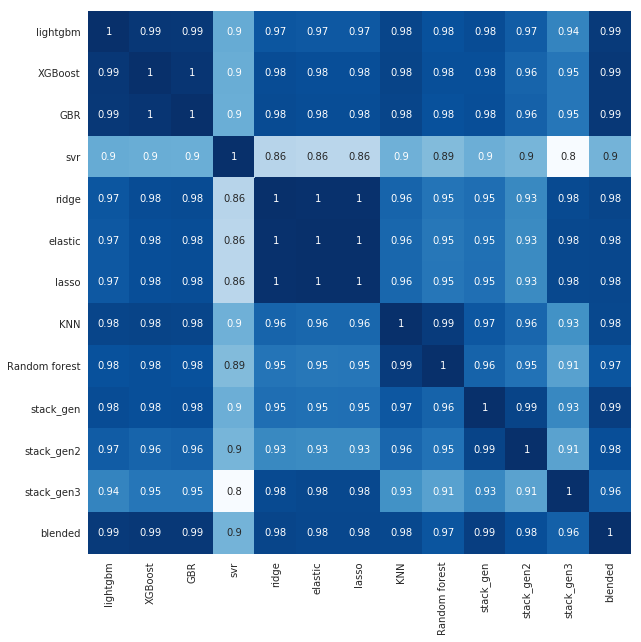

In [41]:
plt.figure(figsize=(10,10))
sns.heatmap(
    preds.corr().round(4), 
    annot=True, 
    cmap="Blues", 
    cbar=False, 
    square=True
   )